# LeafModelRegressor Demo

This notebook demonstrates the `LeafModelRegressor` - a powerful tool for **piecewise modeling** with uncertainty quantification.

## What is LeafModelRegressor?

LeafModelRegressor combines:
1. **Decision Tree** - partitions the input space into regions (leaves)
2. **Custom Models** - fits your choice of model (linear, polynomial, Bayesian) to each region
3. **Uncertainty Quantification** - provides calibrated uncertainties

## When is it useful?

- **Piecewise relationships**: Different behavior in different regions
- **Regime changes**: Physical systems with distinct operating modes
- **Complex nonlinear patterns**: Where a single global model struggles
- **Heteroscedastic noise**: Uncertainty that varies across input space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from pycse.sklearn.leaf_model import LeafModelRegressor

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
np.random.seed(42)

## Example 1: Piecewise Linear Process

**Scenario**: A chemical reactor with two operating regimes
- Low temperature: slow reaction (linear with T)
- High temperature: fast reaction (different linear relationship)

In [2]:
# Generate piecewise linear data
def piecewise_process(T):
    """Reaction rate with regime change at T=400K"""
    return np.where(
        T < 400,
        0.1 * T + 10,  # Low temp regime
        0.5 * T - 150,
    )  # High temp regime


T = np.linspace(300, 500, 200)
rate_true = piecewise_process(T)
rate = rate_true + np.random.normal(0, 2, 200)  # Add noise

# Split data
T_train, T_test, rate_train, rate_test = train_test_split(
    T.reshape(-1, 1), rate, test_size=0.2, random_state=42
)

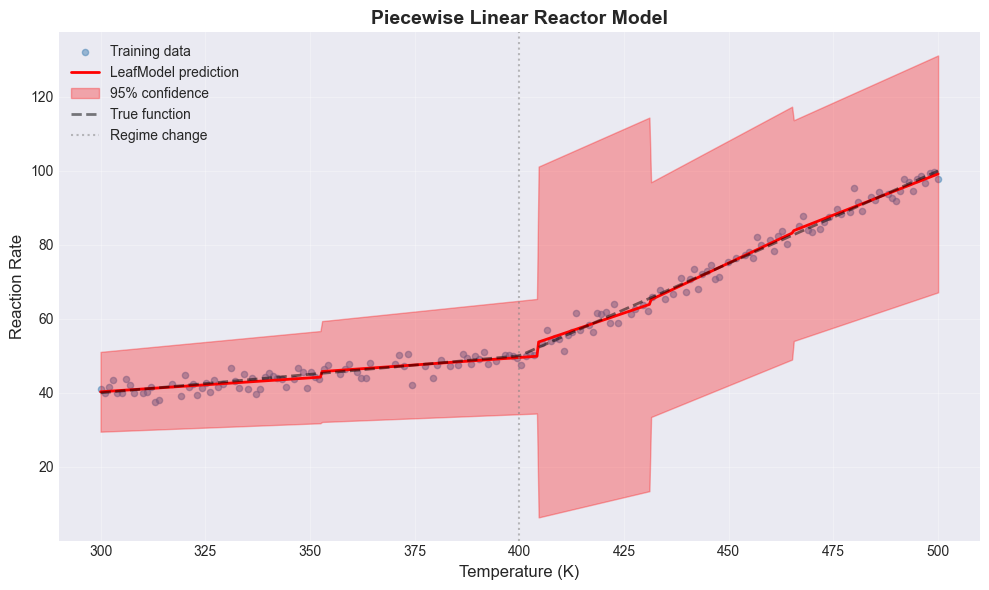


Test R² score: 0.9880


In [3]:
# Fit LeafModelRegressor
leaf_model = LeafModelRegressor(
    leaf_model=BayesianRidge(),  # Use Bayesian Ridge for UQ
    min_samples_leaf=20,  # At least 20 samples per region
    max_depth=3,  # Allow tree to split into regions
)

leaf_model.fit(T_train, rate_train)

# Get predictions with uncertainties
T_plot = np.linspace(300, 500, 500).reshape(-1, 1)
rate_pred, rate_std = leaf_model.predict(T_plot, return_std=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(T_train, rate_train, alpha=0.5, s=20, label="Training data", color="steelblue")
ax.plot(T_plot, rate_pred, "r-", linewidth=2, label="LeafModel prediction")
ax.fill_between(
    T_plot.ravel(),
    rate_pred - 2 * rate_std,
    rate_pred + 2 * rate_std,
    alpha=0.3,
    color="red",
    label="95% confidence",
)
ax.plot(T, rate_true, "k--", linewidth=2, alpha=0.5, label="True function")
ax.axvline(400, color="gray", linestyle=":", alpha=0.5, label="Regime change")
ax.set_xlabel("Temperature (K)", fontsize=12)
ax.set_ylabel("Reaction Rate", fontsize=12)
ax.set_title("Piecewise Linear Reactor Model", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTest R² score: {leaf_model.score(T_test, rate_test):.4f}")

In [4]:
# Display diagnostic report
leaf_model.report()

LeafModelRegressor Summary

Tree Structure:
  Number of leaves: 5
  Maximum depth: 3
  Calibration factor: 1.0000

Leaf Model: BayesianRidge

Leaf Statistics:
  Leaf     N Samples    Y Mean       Y Std        Residual Std   
  ---------------------------------------------------------------
  3        47           42.2899      2.2189       1.8401         
  4        36           47.9963      2.1664       1.7347         
  5        22           58.5424      3.5801       2.0310         
  7        26           74.2455      5.4252       1.7525         
  8        29           92.1773      4.8727       1.7215         


## Example 2: Chemical Kinetics with Temperature Dependence

**Scenario**: Arrhenius equation k = A * exp(-Ea/RT)
- Highly nonlinear
- Different local behaviors at different temperatures
- Polynomial features work better in each local region

In [5]:
# Arrhenius kinetics
R = 8.314  # J/(mol·K)
A = 1e8  # Pre-exponential factor
Ea = 50000  # Activation energy (J/mol)

T = np.linspace(300, 600, 150)
k_true = A * np.exp(-Ea / (R * T))
k = k_true * (1 + 0.1 * np.random.randn(150))  # 10% noise

T_train, T_test, k_train, k_test = train_test_split(
    T.reshape(-1, 1), k, test_size=0.2, random_state=42
)

/Users/jkitchin/Dropbox/python/pycse/src/pycse/sklearn/leaf_model.py:193: UserWarning: 60/500 predictions are outside training data bounds. Extrapolation may be unreliable.
  warnings.warn(


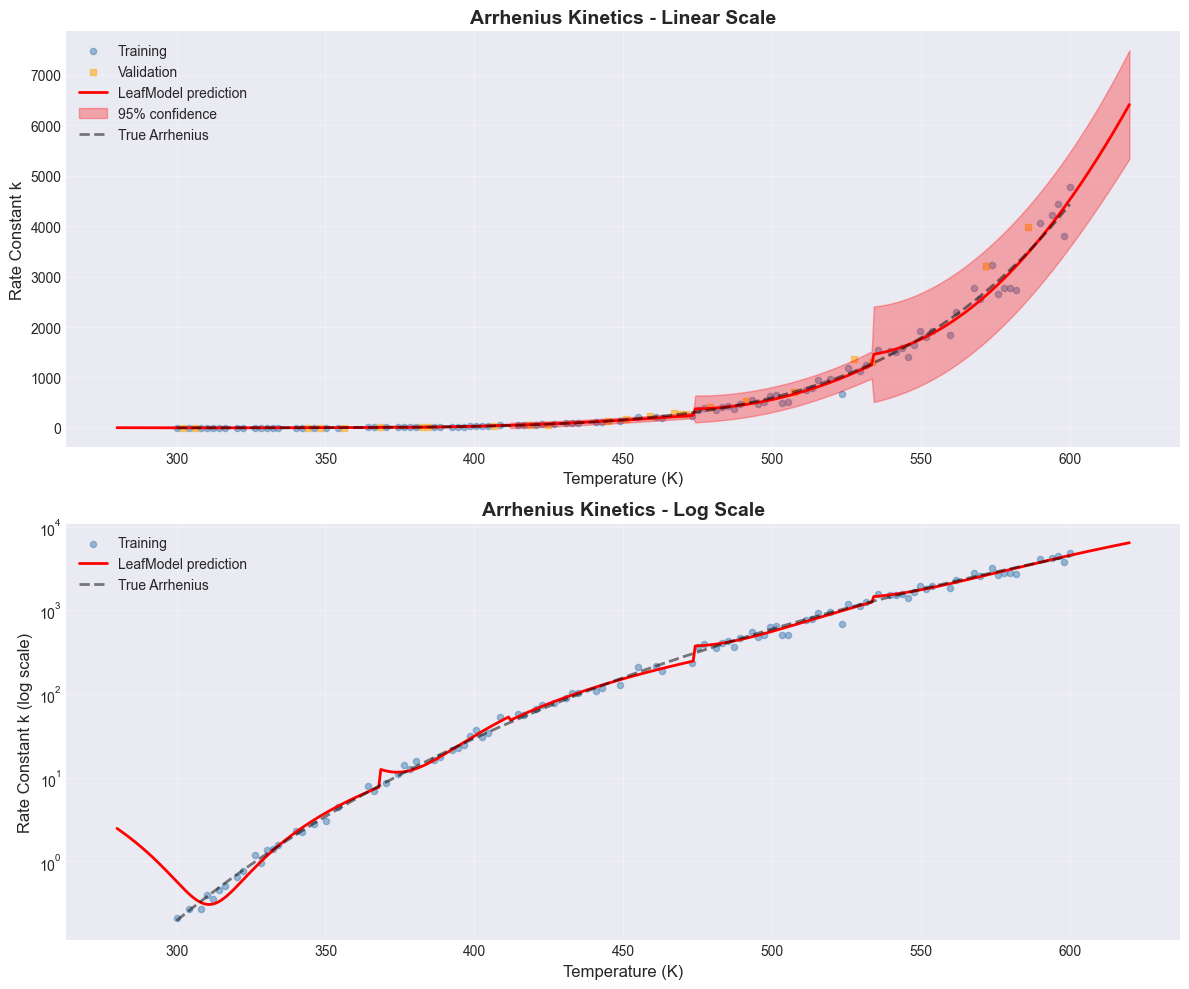

Calibration factor: 0.6236
Test R² score: 0.9811


In [6]:
# Use polynomial features in each leaf
poly_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2)),
        ("ridge", BayesianRidge()),
    ]
)

# Split into validation for calibration
T_train_sub, T_val, k_train_sub, k_val = train_test_split(
    T_train, k_train, test_size=0.2, random_state=42
)

leaf_model = LeafModelRegressor(leaf_model=poly_pipe, min_samples_leaf=15, max_depth=4)

# Fit with calibration
leaf_model.fit(T_train_sub, k_train_sub, val_X=T_val, val_y=k_val)

# Predictions
T_plot = np.linspace(280, 620, 500).reshape(-1, 1)
k_pred, k_std = leaf_model.predict(T_plot, return_std=True)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Linear scale
ax1.scatter(T_train_sub, k_train_sub, alpha=0.5, s=20, label="Training", color="steelblue")
ax1.scatter(T_val, k_val, alpha=0.5, s=20, label="Validation", color="orange", marker="s")
ax1.plot(T_plot, k_pred, "r-", linewidth=2, label="LeafModel prediction")
ax1.fill_between(
    T_plot.ravel(),
    k_pred - 2 * k_std,
    k_pred + 2 * k_std,
    alpha=0.3,
    color="red",
    label="95% confidence",
)
ax1.plot(T, k_true, "k--", linewidth=2, alpha=0.5, label="True Arrhenius")
ax1.set_xlabel("Temperature (K)", fontsize=12)
ax1.set_ylabel("Rate Constant k", fontsize=12)
ax1.set_title("Arrhenius Kinetics - Linear Scale", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale
ax2.scatter(T_train_sub, k_train_sub, alpha=0.5, s=20, label="Training", color="steelblue")
ax2.plot(T_plot, k_pred, "r-", linewidth=2, label="LeafModel prediction")
ax2.plot(T, k_true, "k--", linewidth=2, alpha=0.5, label="True Arrhenius")
ax2.set_xlabel("Temperature (K)", fontsize=12)
ax2.set_ylabel("Rate Constant k (log scale)", fontsize=12)
ax2.set_title("Arrhenius Kinetics - Log Scale", fontsize=14, fontweight="bold")
ax2.set_yscale("log")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Calibration factor: {leaf_model.calibration_factor_:.4f}")
print(f"Test R² score: {leaf_model.score(T_test, k_test):.4f}")

In [7]:
# Check uncertainty calibration
leaf_model.print_metrics(T_test, k_test)


Uncertainty Quantification Metrics

Prediction Quality:
  R² Score:              0.9811
  RMSE:                  156.9465
  MAE:                   66.5144

Uncertainty Calibration:
  Mean |Z-score|:        0.4311 (ideal: 0.798)
  Std Z-score:           0.5449 (ideal: 1.000)
  NLL:                   4.2163
  Miscalibration Area:   0.0885 (ideal: 0.000)

Coverage:
  Within 1σ:             90.0% (ideal: 68.3%)
  Within 2σ:             100.0% (ideal: 95.4%)
  Within 3σ:             100.0% (ideal: 99.7%)

Uncertainty Statistics:
  Mean uncertainty:      142.6369
  Std uncertainty:       193.6758



## Example 3: Multi-Phase Material Property

**Scenario**: Heat capacity of water across phase transitions
- Ice (< 273K): ~2.1 kJ/(kg·K)
- Water (273-373K): ~4.2 kJ/(kg·K)  
- Steam (> 373K): ~2.0 kJ/(kg·K)
- Sharp discontinuities at phase boundaries

In [8]:
# Generate multi-phase data
def heat_capacity(T):
    """Heat capacity with phase transitions"""
    cp = np.zeros_like(T)
    cp[T < 273] = 2.1  # Ice
    cp[(T >= 273) & (T < 373)] = 4.2  # Water
    cp[T >= 373] = 2.0  # Steam
    return cp


T = np.concatenate(
    [
        np.linspace(250, 272, 50),  # Ice region
        np.linspace(274, 372, 100),  # Water region
        np.linspace(374, 400, 50),  # Steam region
    ]
)

cp_true = heat_capacity(T)
cp = cp_true + np.random.normal(0, 0.1, 200)  # Add measurement noise

T_train, T_test, cp_train, cp_test = train_test_split(
    T.reshape(-1, 1), cp, test_size=0.2, random_state=42
)

/Users/jkitchin/Dropbox/python/pycse/src/pycse/sklearn/leaf_model.py:193: UserWarning: 32/500 predictions are outside training data bounds. Extrapolation may be unreliable.
  warnings.warn(


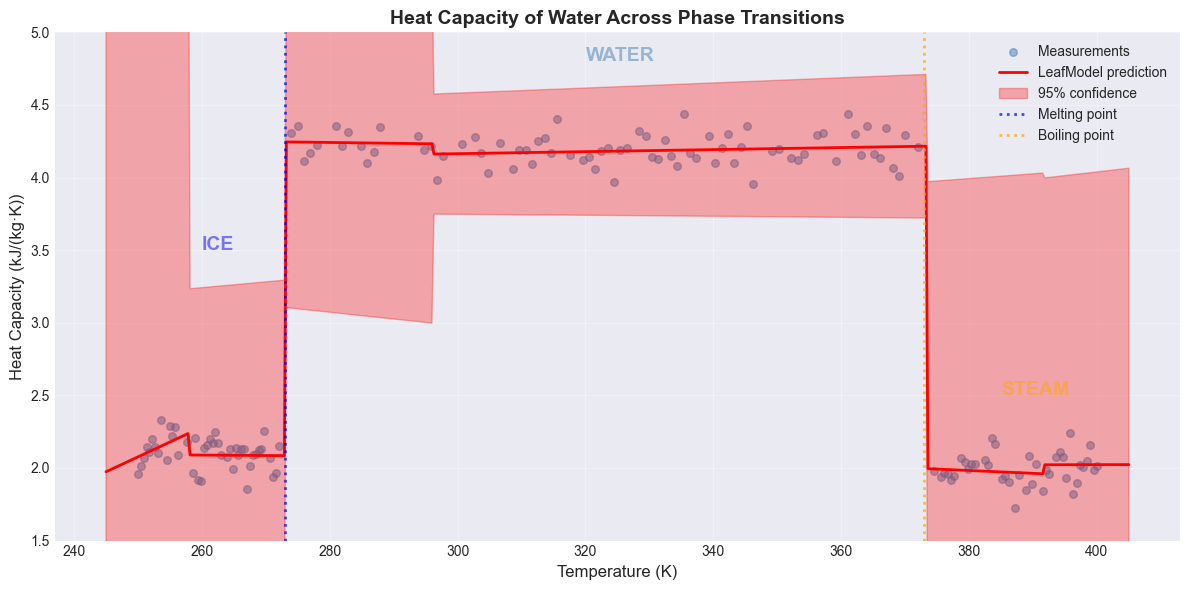


Test R² score: 0.9884


In [9]:
# Fit LeafModel
leaf_model = LeafModelRegressor(leaf_model=BayesianRidge(), min_samples_leaf=15, max_depth=3)

leaf_model.fit(T_train, cp_train)

# Predictions
T_plot = np.linspace(245, 405, 500).reshape(-1, 1)
cp_pred, cp_std = leaf_model.predict(T_plot, return_std=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(T_train, cp_train, alpha=0.5, s=30, label="Measurements", color="steelblue")
ax.plot(T_plot, cp_pred, "r-", linewidth=2, label="LeafModel prediction")
ax.fill_between(
    T_plot.ravel(),
    cp_pred - 2 * cp_std,
    cp_pred + 2 * cp_std,
    alpha=0.3,
    color="red",
    label="95% confidence",
)

# Add phase boundaries
ax.axvline(273, color="blue", linestyle=":", linewidth=2, alpha=0.7, label="Melting point")
ax.axvline(373, color="orange", linestyle=":", linewidth=2, alpha=0.7, label="Boiling point")

# Add phase labels
ax.text(260, 3.5, "ICE", fontsize=14, fontweight="bold", color="blue", alpha=0.5)
ax.text(320, 4.8, "WATER", fontsize=14, fontweight="bold", color="steelblue", alpha=0.5)
ax.text(385, 2.5, "STEAM", fontsize=14, fontweight="bold", color="orange", alpha=0.5)

ax.set_xlabel("Temperature (K)", fontsize=12)
ax.set_ylabel("Heat Capacity (kJ/(kg·K))", fontsize=12)
ax.set_title("Heat Capacity of Water Across Phase Transitions", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
ax.set_ylim([1.5, 5.0])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTest R² score: {leaf_model.score(T_test, cp_test):.4f}")

## Example 4: Heteroscedastic Uncertainty

**Scenario**: Measurement uncertainty that increases with signal
- Common in analytical chemistry, spectroscopy
- Low concentration: small absolute error
- High concentration: larger absolute error

In [10]:
# Generate heteroscedastic data
concentration = np.linspace(0, 100, 200)
signal_true = 2.5 * concentration + 10  # Linear calibration curve

# Noise increases with concentration
noise_std = 1 + 0.5 * concentration
signal = signal_true + noise_std * np.random.randn(200)

c_train, c_test, s_train, s_test = train_test_split(
    concentration.reshape(-1, 1), signal, test_size=0.2, random_state=42
)

/Users/jkitchin/Dropbox/python/pycse/src/pycse/sklearn/leaf_model.py:193: UserWarning: 48/500 predictions are outside training data bounds. Extrapolation may be unreliable.
  warnings.warn(


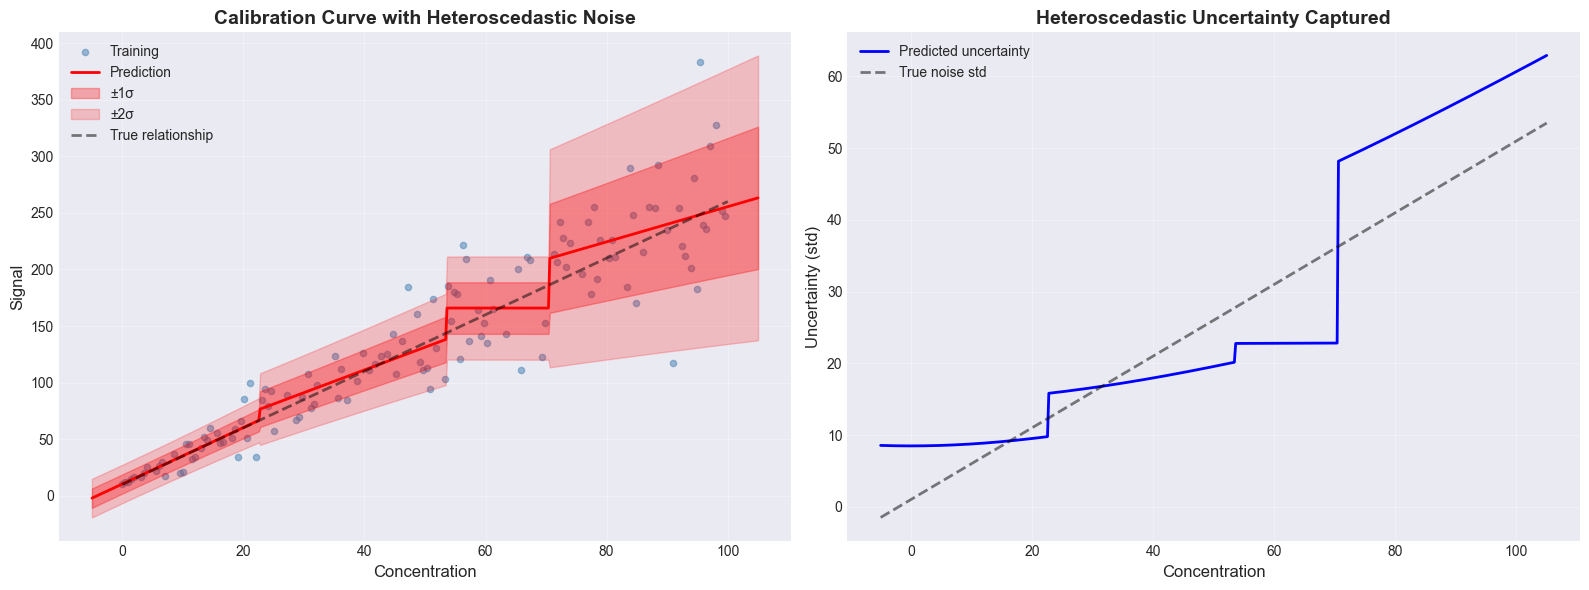


Calibration factor: 0.7053
Test R² score: 0.7932


In [11]:
# Fit LeafModel with calibration
c_train_sub, c_val, s_train_sub, s_val = train_test_split(
    c_train, s_train, test_size=0.2, random_state=42
)

leaf_model = LeafModelRegressor(leaf_model=BayesianRidge(), min_samples_leaf=20, max_depth=4)

leaf_model.fit(c_train_sub, s_train_sub, val_X=c_val, val_y=s_val)

# Predictions
c_plot = np.linspace(-5, 105, 500).reshape(-1, 1)
s_pred, s_std = leaf_model.predict(c_plot, return_std=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Predictions with uncertainties
ax1.scatter(c_train_sub, s_train_sub, alpha=0.5, s=20, label="Training", color="steelblue")
ax1.plot(c_plot, s_pred, "r-", linewidth=2, label="Prediction")
ax1.fill_between(
    c_plot.ravel(), s_pred - s_std, s_pred + s_std, alpha=0.3, color="red", label="±1σ"
)
ax1.fill_between(
    c_plot.ravel(), s_pred - 2 * s_std, s_pred + 2 * s_std, alpha=0.2, color="red", label="±2σ"
)
ax1.plot(concentration, signal_true, "k--", linewidth=2, alpha=0.5, label="True relationship")
ax1.set_xlabel("Concentration", fontsize=12)
ax1.set_ylabel("Signal", fontsize=12)
ax1.set_title("Calibration Curve with Heteroscedastic Noise", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Uncertainty vs concentration
ax2.plot(c_plot, s_std, "b-", linewidth=2, label="Predicted uncertainty")
true_noise = 1 + 0.5 * c_plot.ravel()
ax2.plot(c_plot, true_noise, "k--", linewidth=2, alpha=0.5, label="True noise std")
ax2.set_xlabel("Concentration", fontsize=12)
ax2.set_ylabel("Uncertainty (std)", fontsize=12)
ax2.set_title("Heteroscedastic Uncertainty Captured", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCalibration factor: {leaf_model.calibration_factor_:.4f}")
print(f"Test R² score: {leaf_model.score(c_test, s_test):.4f}")

In [12]:
# Detailed uncertainty metrics
leaf_model.print_metrics(c_test, s_test)


Uncertainty Quantification Metrics

Prediction Quality:
  R² Score:              0.7932
  RMSE:                  34.8092
  MAE:                   24.0823

Uncertainty Calibration:
  Mean |Z-score|:        0.9801 (ideal: 0.798)
  Std Z-score:           1.4112 (ideal: 1.000)
  NLL:                   5.0596
  Miscalibration Area:   0.0365 (ideal: 0.000)

Coverage:
  Within 1σ:             67.5% (ideal: 68.3%)
  Within 2σ:             92.5% (ideal: 95.4%)
  Within 3σ:             92.5% (ideal: 99.7%)

Uncertainty Statistics:
  Mean uncertainty:      27.2391
  Std uncertainty:       16.6738



## Comparison: Global vs Piecewise Modeling

Let's compare LeafModel with a global polynomial model on piecewise data

In [13]:
# Generate complex piecewise data
x = np.linspace(0, 10, 300)
y_true = np.piecewise(
    x,
    [x < 2.5, (x >= 2.5) & (x < 5), (x >= 5) & (x < 7.5), x >= 7.5],
    [
        lambda x: x**2,  # Quadratic
        lambda x: 2 * x + 0.5,  # Linear
        lambda x: -2 * x + 25,  # Linear (opposite slope)
        lambda x: 0.5 * (x - 7.5) ** 2 + 10,
    ],  # Quadratic
)
y = y_true + np.random.normal(0, 0.5, 300)

X_train, X_test, y_train, y_test = train_test_split(
    x.reshape(-1, 1), y, test_size=0.2, random_state=42
)

/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jkitchin/Dropbox/python/pycse/src/pycse/sklearn/leaf_model.py:193: UserWarning: 46/500 predictions are outside training data bounds. Extrapolation may be unreliable.
  warnings.warn(


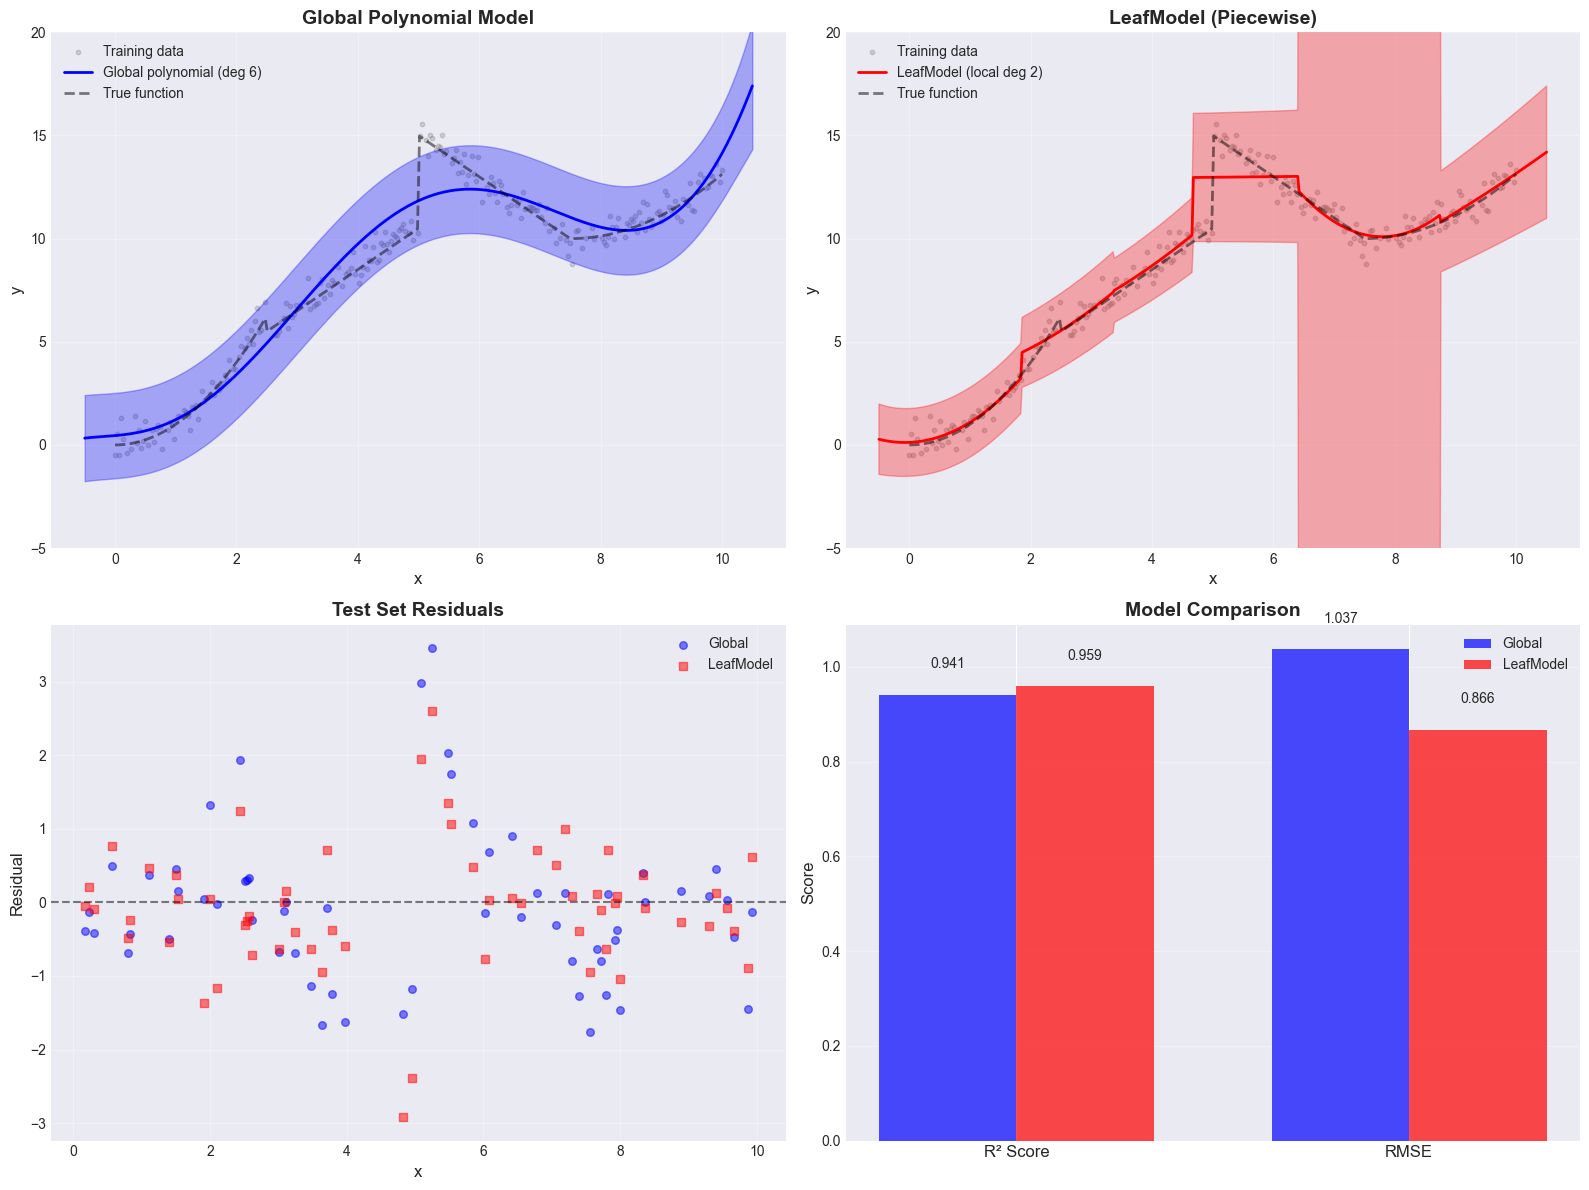


MODEL COMPARISON
Global Polynomial (deg 6):
  R² Score: 0.9410
  RMSE:     1.0367

LeafModel (local deg 2):
  R² Score: 0.9588
  RMSE:     0.8665

Improvement: 1.9% better R²


In [14]:
# Global polynomial model
global_poly = Pipeline([("poly", PolynomialFeatures(degree=6)), ("ridge", BayesianRidge())])
global_poly.fit(X_train, y_train)

# LeafModel with local polynomials
local_poly = Pipeline([("poly", PolynomialFeatures(degree=2)), ("ridge", BayesianRidge())])

leaf_model = LeafModelRegressor(leaf_model=local_poly, min_samples_leaf=30, max_depth=4)
leaf_model.fit(X_train, y_train)

# Predictions
x_plot = np.linspace(-0.5, 10.5, 500).reshape(-1, 1)
y_global, y_global_std = global_poly.predict(x_plot, return_std=True)
y_leaf, y_leaf_std = leaf_model.predict(x_plot, return_std=True)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Global model
ax = axes[0, 0]
ax.scatter(X_train, y_train, alpha=0.3, s=10, color="gray", label="Training data")
ax.plot(x_plot, y_global, "b-", linewidth=2, label="Global polynomial (deg 6)")
ax.fill_between(
    x_plot.ravel(),
    y_global - 2 * y_global_std,
    y_global + 2 * y_global_std,
    alpha=0.3,
    color="blue",
)
ax.plot(x, y_true, "k--", linewidth=2, alpha=0.5, label="True function")
ax.set_title("Global Polynomial Model", fontsize=14, fontweight="bold")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([-5, 20])

# LeafModel
ax = axes[0, 1]
ax.scatter(X_train, y_train, alpha=0.3, s=10, color="gray", label="Training data")
ax.plot(x_plot, y_leaf, "r-", linewidth=2, label="LeafModel (local deg 2)")
ax.fill_between(
    x_plot.ravel(), y_leaf - 2 * y_leaf_std, y_leaf + 2 * y_leaf_std, alpha=0.3, color="red"
)
ax.plot(x, y_true, "k--", linewidth=2, alpha=0.5, label="True function")
ax.set_title("LeafModel (Piecewise)", fontsize=14, fontweight="bold")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([-5, 20])

# Residuals comparison
ax = axes[1, 0]
y_test_global = global_poly.predict(X_test)
y_test_leaf = leaf_model.predict(X_test, warn_extrapolation=False)
residuals_global = y_test - y_test_global
residuals_leaf = y_test - y_test_leaf

ax.scatter(X_test, residuals_global, alpha=0.5, s=30, color="blue", label="Global")
ax.scatter(X_test, residuals_leaf, alpha=0.5, s=30, color="red", marker="s", label="LeafModel")
ax.axhline(0, color="k", linestyle="--", alpha=0.5)
ax.set_title("Test Set Residuals", fontsize=14, fontweight="bold")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("Residual", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Score comparison
ax = axes[1, 1]
global_r2 = global_poly.score(X_test, y_test)
leaf_r2 = leaf_model.score(X_test, y_test)
global_rmse = np.sqrt(np.mean(residuals_global**2))
leaf_rmse = np.sqrt(np.mean(residuals_leaf**2))

metrics = ["R² Score", "RMSE"]
global_scores = [global_r2, global_rmse]
leaf_scores = [leaf_r2, leaf_rmse]

x_pos = np.arange(len(metrics))
width = 0.35

ax.bar(x_pos - width / 2, global_scores, width, label="Global", color="blue", alpha=0.7)
ax.bar(x_pos + width / 2, leaf_scores, width, label="LeafModel", color="red", alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Model Comparison", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for i, (g, leaf_val) in enumerate(zip(global_scores, leaf_scores)):
    ax.text(i - width / 2, g + 0.05, f"{g:.3f}", ha="center", va="bottom", fontsize=10)
    ax.text(
        i + width / 2, leaf_val + 0.05, f"{leaf_val:.3f}", ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print("Global Polynomial (deg 6):")
print(f"  R² Score: {global_r2:.4f}")
print(f"  RMSE:     {global_rmse:.4f}")
print("\nLeafModel (local deg 2):")
print(f"  R² Score: {leaf_r2:.4f}")
print(f"  RMSE:     {leaf_rmse:.4f}")
print(f"\nImprovement: {(leaf_r2 - global_r2)/global_r2 * 100:.1f}% better R²")
print("=" * 60)

## Key Takeaways

### When to use LeafModelRegressor:

1. **Piecewise relationships** - Different behaviors in different regions
2. **Regime changes** - Physical systems with distinct operating modes  
3. **Local complexity** - Simple local models work better than complex global models
4. **Heteroscedastic uncertainty** - Uncertainty varies across input space
5. **Interpretability** - Want to understand different regimes

### Advantages:

- ✅ Automatically discovers piecewise structure
- ✅ Uses simple models in each region (interpretable)
- ✅ Provides calibrated uncertainties
- ✅ Handles heteroscedastic noise naturally
- ✅ Flexible - any sklearn estimator as leaf model

### Limitations:

- ⚠️ Tree splits based on MSE, not leaf model performance (non-optimal)
- ⚠️ Requires sufficient samples per leaf
- ⚠️ Extrapolation beyond training bounds may be unreliable
- ⚠️ More complex than global models (more hyperparameters)

### Best Practices:

1. Use `min_samples_leaf` to ensure stable leaf models
2. Provide validation data for calibration
3. Use `BayesianRidge` or similar for uncertainty quantification
4. Check `report()` to understand learned structure
5. Validate with `uncertainty_metrics()` and `print_metrics()`